
# Titanic EDA, Cleaning, and Visualization (Pandas + Matplotlib)

**Objectives**  
- Explore the classic Titanic dataset using Python  
- Handle missing values and convert types  
- Generate summary statistics and group-based insights (e.g., survival by gender/class)  
- Visualize key patterns and correlations  

**Tools**: Python, Pandas, Matplotlib (no seaborn)


In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Matplotlib rendering in notebooks
%matplotlib inline


In [ ]:

# ---- File paths ----
# Update these if your CSVs are in a different folder
train_path = "/content/train.csv"
test_path = "/content/test.csv"


In [ ]:

# ---- Load data ----
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

print(f"Train shape: {train.shape}")
print(f"Test shape:  {test.shape}")

train.head()


Train shape: (891, 12)
Test shape:  (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:

# ---- Schema & missing summary ----
def schema_and_missing(df):
    return pd.DataFrame({
        "column": df.columns,
        "dtype": df.dtypes.astype(str).values,
        "missing_count": df.isna().sum().values,
        "missing_%": (df.isna().mean().values * 100).round(2),
        "unique_values": [df[c].nunique(dropna=True) for c in df.columns]
    })

schema_and_missing(train)


,column,dtype,missing_count,missing_%,unique_values
0,PassengerId,int64,0,0.00,891
1,Survived,int64,0,0.00,2
2,Pclass,int64,0,0.00,3
3,Name,object,0,0.00,891
4,Sex,object,0,0.00,2
5,Age,float64,177,19.87,88
6,SibSp,int64,0,0.00,7
7,Parch,int64,0,0.00,7
8,Ticket,object,0,0.00,681
9,Fare,float64,0,0.00,248


In [ ]:

# ---- Numeric summary ----
train.describe(include=[np.number]).T


,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


In [ ]:

# ---- Cleaning parameters learned from train ----
embark_mode = train["Embarked"].mode(dropna=True)[0] if train["Embarked"].notna().any() else "S"
age_by_sex_pclass = train.groupby(["Sex", "Pclass"])["Age"].median()
age_overall_median = train["Age"].median()
fare_overall_median = pd.concat([train["Fare"], test["Fare"]]).median()

embark_mode, age_overall_median, fare_overall_median


('S', 28.0, 14.4542)

In [ ]:

# ---- Cleaning helpers ----
def fill_age(row):
    key = (row["Sex"], row["Pclass"])
    if pd.isna(row["Age"]):
        if key in age_by_sex_pclass.index and not np.isnan(age_by_sex_pclass.loc[key]):
            return age_by_sex_pclass.loc[key]
        return age_overall_median
    return row["Age"]

# ---- Clean train ----
train_clean = train.copy()
train_clean["Embarked"] = train_clean["Embarked"].fillna(embark_mode)
train_clean["Age"] = train_clean.apply(fill_age, axis=1)
train_clean["Fare"] = train_clean["Fare"].fillna(fare_overall_median)
train_clean["HasCabin"] = train_clean["Cabin"].notna().astype(int)
train_clean = train_clean.drop(columns=["Cabin", "Ticket"])
for col in ["Pclass", "Sex", "Embarked"]:
    train_clean[col] = train_clean[col].astype("category")

schema_and_missing(train_clean)


,column,dtype,missing_count,missing_%,unique_values
0,PassengerId,int64,0,0.0,891
1,Survived,int64,0,0.0,2
2,Pclass,category,0,0.0,3
3,Name,object,0,0.0,891
4,Sex,category,0,0.0,2
5,Age,float64,0,0.0,89
6,SibSp,int64,0,0.0,7
7,Parch,int64,0,0.0,7
8,Fare,float64,0,0.0,248
9,Embarked,category,0,0.0,3


In [ ]:

# ---- Clean test ----
test_clean = test.copy()
test_clean["Embarked"] = test_clean["Embarked"].fillna(embark_mode)

def fill_age_test(row):
    key = (row["Sex"], row["Pclass"])
    if pd.isna(row["Age"]):
        if key in age_by_sex_pclass.index and not np.isnan(age_by_sex_pclass.loc[key]):
            return age_by_sex_pclass.loc[key]
        return age_overall_median
    return row["Age"]

test_clean["Age"] = test_clean.apply(fill_age_test, axis=1)
test_clean["Fare"] = test_clean["Fare"].fillna(fare_overall_median)
test_clean["HasCabin"] = test_clean["Cabin"].notna().astype(int)
test_clean = test_clean.drop(columns=["Cabin", "Ticket"])
for col in ["Pclass", "Sex", "Embarked"]:
    if col in test_clean.columns:
        test_clean[col] = test_clean[col].astype("category")

schema_and_missing(test_clean)


,column,dtype,missing_count,missing_%,unique_values
0,PassengerId,int64,0,0.0,418
1,Pclass,category,0,0.0,3
2,Name,object,0,0.0,418
3,Sex,category,0,0.0,2
4,Age,float64,0,0.0,80
5,SibSp,int64,0,0.0,7
6,Parch,int64,0,0.0,8
7,Fare,float64,0,0.0,169
8,Embarked,category,0,0.0,3
9,HasCabin,int64,0,0.0,2


In [ ]:

# ---- Group-based survival insights ----
surv_by_sex = train_clean.groupby("Sex")["Survived"].mean().rename("survival_rate").reset_index()
surv_by_pclass = train_clean.groupby("Pclass")["Survived"].mean().rename("survival_rate").reset_index()
surv_by_embarked = train_clean.groupby("Embarked")["Survived"].mean().rename("survival_rate").reset_index()
pivot_sex_pclass = train_clean.pivot_table(index="Sex", columns="Pclass", values="Survived", aggfunc="mean")

surv_by_sex, surv_by_pclass, surv_by_embarked, pivot_sex_pclass


/tmp/ipython-input-2705744472.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  surv_by_sex = train_clean.groupby("Sex")["Survived"].mean().rename("survival_rate").reset_index()
/tmp/ipython-input-2705744472.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  surv_by_pclass = train_clean.groupby("Pclass")["Survived"].mean().rename("survival_rate").reset_index()
/tmp/ipython-input-2705744472.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and 

(      Sex  survival_rate
 0  female       0.742038
 1    male       0.188908,
   Pclass  survival_rate
 0      1       0.629630
 1      2       0.472826
 2      3       0.242363,
   Embarked  survival_rate
 0        C       0.553571
 1        Q       0.389610
 2        S       0.339009,
 Pclass         1         2         3
 Sex                                 
 female  0.968085  0.921053  0.500000
 male    0.368852  0.157407  0.135447)

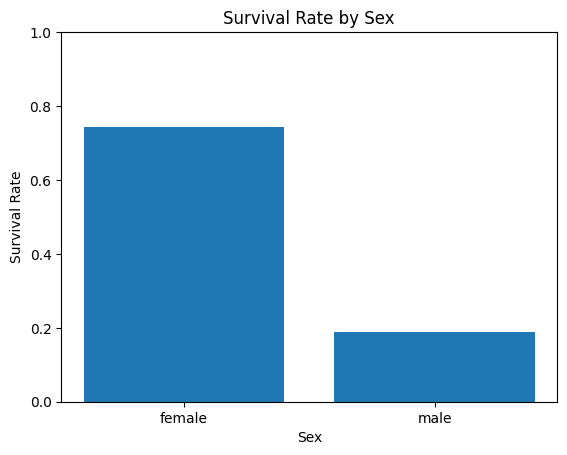

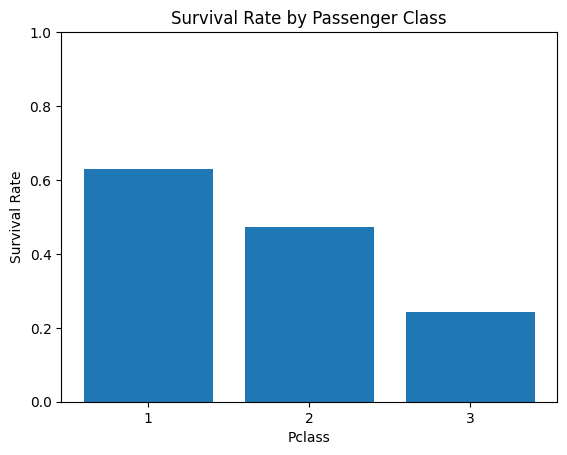

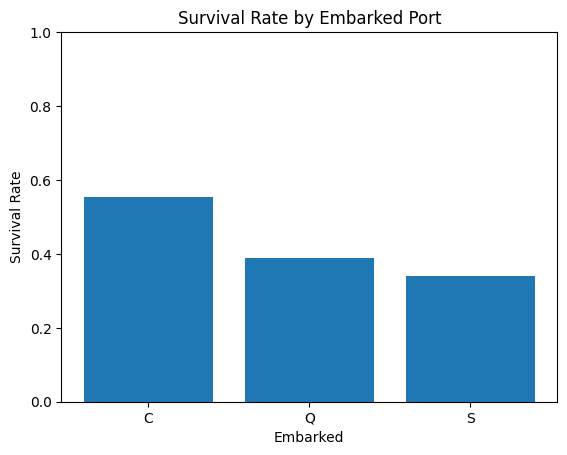

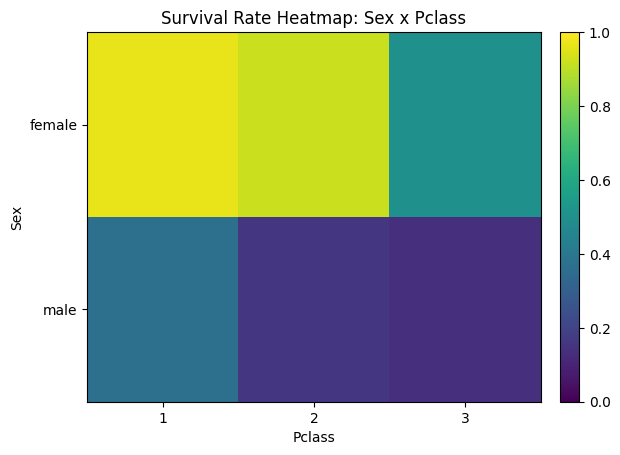

In [ ]:

# ---- Plots (Matplotlib only; default colors; one figure per plot) ----

# Bar: Survival by Sex
plt.figure()
plt.bar(surv_by_sex["Sex"].astype(str), surv_by_sex["survival_rate"])
plt.title("Survival Rate by Sex")
plt.xlabel("Sex")
plt.ylabel("Survival Rate")
plt.ylim(0, 1)
plt.show()

# Bar: Survival by Pclass
plt.figure()
plt.bar(surv_by_pclass["Pclass"].astype(str), surv_by_pclass["survival_rate"])
plt.title("Survival Rate by Passenger Class")
plt.xlabel("Pclass")
plt.ylabel("Survival Rate")
plt.ylim(0, 1)
plt.show()

# Bar: Survival by Embarked
plt.figure()
plt.bar(surv_by_embarked["Embarked"].astype(str), surv_by_embarked["survival_rate"])
plt.title("Survival Rate by Embarked Port")
plt.xlabel("Embarked")
plt.ylabel("Survival Rate")
plt.ylim(0, 1)
plt.show()

# Heatmap: Sex x Pclass
plt.figure()
im = plt.imshow(pivot_sex_pclass.values, aspect="auto")
plt.title("Survival Rate Heatmap: Sex x Pclass")
plt.xlabel("Pclass")
plt.ylabel("Sex")
plt.xticks(ticks=np.arange(pivot_sex_pclass.shape[1]), labels=[str(c) for c in pivot_sex_pclass.columns])
plt.yticks(ticks=np.arange(pivot_sex_pclass.shape[0]), labels=pivot_sex_pclass.index.astype(str))
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.clim(0, 1)
plt.show()


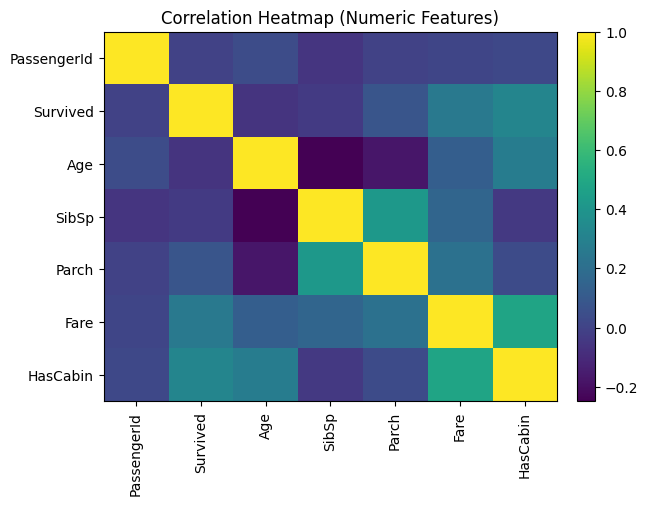

,PassengerId,Survived,Age,SibSp,Parch,Fare,HasCabin
PassengerId,1.000000,-0.005007,0.039033,-0.057527,-0.001652,0.012658,0.019919
Survived,-0.005007,1.000000,-0.059579,-0.035322,0.081629,0.257307,0.316912
Age,0.039033,-0.059579,1.000000,-0.249854,-0.175526,0.122692,0.277022
SibSp,-0.057527,-0.035322,-0.249854,1.000000,0.414838,0.159651,-0.040460
Parch,-0.001652,0.081629,-0.175526,0.414838,1.000000,0.216225,0.036987
Fare,0.012658,0.257307,0.122692,0.159651,0.216225,1.000000,0.482075
HasCabin,0.019919,0.316912,0.277022,-0.040460,0.036987,0.482075,1.000000


In [ ]:

# ---- Correlation heatmap (numeric columns only) ----
numeric_cols = train_clean.select_dtypes(include=[np.number]).columns
corr = train_clean[numeric_cols].corr()

plt.figure()
im2 = plt.imshow(corr.values, aspect="auto")
plt.title("Correlation Heatmap (Numeric Features)")
plt.xticks(ticks=np.arange(len(numeric_cols)), labels=numeric_cols, rotation=90)
plt.yticks(ticks=np.arange(len(numeric_cols)), labels=numeric_cols)
plt.colorbar(im2, fraction=0.046, pad=0.04)
plt.show()

corr


In [ ]:

# ---- Save cleaned datasets ----
train_clean.to_csv("cleaned_train.csv", index=False)
test_clean.to_csv("cleaned_test.csv", index=False)
print("Saved cleaned_train.csv and cleaned_test.csv")


Saved cleaned_train.csv and cleaned_test.csv
